# Image Segmentation of Microvascular Structures in Kidney Tissues

### Introduction to the problem

The goal of this project is to develop an image segmentation model for microvascular structures in human kidney tissue, focusing on arterioles, capillaries, and venules. In the dataset, there are two primary target structures that need to be segmented and identified:

- Blood Vessels: These are tubular structures that transport blood throughout the body. These microvascular structures (arterioles, capillaries, and venules) are responsible for the blood flow in the kidney tissue.
- Glomerulus: This is a specific capillary ball structure found in the kidney. It plays a crucial role in blood filtration within the kidney’s nephron.

The dataset consists of 2D histology images (cross-sectional images) of kidney tissue stained with Periodic Acid-Schiff (PAS). PAS is a special purple-magenta colored stain that highlights certain structures in the tissue. Microvascular structures play a crucial role in maintaining the kidney's function of blood filtration and waste removal. Accurately segmenting these structures will provide valuable insights into their arrangement within the kidney and contribute to a deeper understanding of the organ's functionality.

Researchers aim to use this data to contribute to the creation of the Vascular Common Coordinate Framework (VCCF), which will map blood vessel structures across the human body. The segmentation of microvasculature could significantly improve the VCCF by filling in existing gaps in our knowledge of vascular arrangements, which are critical to understand various biological processes and diseases.

---
### Data description

1. Images: The image data is provided in TIFF format, with each tile being 512x512 pixels in size.
2. Masks: The segmentation masks are stored in a JSON file called polygons.jsonl.

   Each line in the file corresponds to one image and includes:
   - 'id': Identifies the corresponding image in the folder.
   - 'annotations': A list of mask annotations for the image, each containing:
       - 'type': The type of structure (class) annotated. There are three classes:
           - 'blood_vessel': Tubular structures (arterioles, capillaries, and venules).
           - 'glomerulus': The capillary ball structure involved in filtration.
           - 'unsure': This class is not required for segmentation purposes (might confuse the model).
        - 'coordinates': A list of polygon coordinates defining the segmentation mask.
   

### Data reading and preprocessing

#### Importing modules

In [1]:
# Basic data processing modules
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from sklearn.model_selection import KFold
from scipy.ndimage import label
from datetime import datetime
import pandas as pd
import numpy as np
import random
import json
import os
import gc
import cv2

# Import pytorch modules
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import transforms
from torch.nn.functional import relu
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

# Settings for ideal prints
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 999)

# Set seed for reproduction
seed_value = 123
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value) # In case we use GPU

# Ensure deterministic behavior for GPU operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable benchmarking to ensure deterministic algorithms

# Use GPU memory for training if available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device: cuda


#### Parameter configurations

These specific parameter configurations are addressed for a convolutional model training. I will attempt to use a UNet model for this segmentation project, that will be introduced in details later in the notebook.

In [2]:
class CFG:
    # Dataset parameters
    base_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/"
    images_folder = os.path.join(base_path, "train")
    labels_path = os.path.join(base_path, "polygons.jsonl")
    sample_size = None  # None if we need all data otherwise set the number of samples

    # Image augmentation setting
    transformations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.GaussianBlur(blur_limit=(3, 9), p=0.5), # max blurring kernel is 9
        A.ElasticTransform(alpha=20, sigma=50, p=0.5), # careful setting, might requires expert insight
        A.ShiftScaleRotate(shift_limit=0, scale_limit=(-0.2, 0.2), rotate_limit=0, interpolation=1, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.CLAHE(clip_limit=2.0, p=0.5), # equalize colors based on histogram (might not needed since the images are stained?)
    ])

    # Model related parameters
    img_size = 512     # size of sample image
    in_ch = 3          # input bands of an image
    num_classes = 3    # background + 2 classes
    filters = 16       # initial number of convolutional filters of the model
    mixed_precision = True # mixing dtypes (float16 and float32) for faster computation

    # Training hyperparameters
    epochs = 50         # number of training iterations
    batch_size = 16     # grouping samples for better calculation (memory and training speed tradeoff)
    init_lr = 1e-3      # initial learning rate for optimizer
    weight_decay = 1e-3 # regularization parameter
    early_stopping = 5  # patience in case of training decline
    lr_patience = 1     # patience for changing the learning in case of training decline 
    lr_factor = 0.3     # rate of change in case of training decline
    t_max = 8           # cosine annealing parameter (for cyclical learning rate)
    eta_min = 5e-7      # cosine annealing minimum learning rate

    # Dictionaries for statistics and other mapping options
    cls_dict = {"background":0, "blood_vessel":1, "glomerulus":2}
    cnt_dict = {"background":0, "blood_vessel":0, "glomerulus":0}

### Custom dataset

In order to load in and prepare the images and masks, we need to create a Pytorch specific dataset class.

Previously I tried to use one-hot encoded masks to train the model, and it didn't provided very efficient segmentation results, so I decided to use label-encoded masks instead (which shouldn't be a problem, since we know the intersection of classes is insignificant). This way I could achieve faster and better training results.

In [3]:
class HubMap_Dataset(Dataset):
    def __init__(self, image_dir, labels_file, sample_size=None, augmentation=None):
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.sample_size = sample_size
        self.augmentation = augmentation
        self.dataset = HubMap_Dataset.create_dataframe(self.labels_file, self.sample_size)

    @staticmethod
    def coordinates_to_mask(coordinate_list, class_num):
        """ Convert polygon coordinates to a mask with a specific class label. """
        mask = np.zeros((512, 512), dtype=np.uint8)
        for coord in coordinate_list:
            cv2.fillPoly(mask, [np.array(coord)], class_num)
        return mask

    @staticmethod
    def create_dataframe(labels_file, sample_size=None):
        """ 
        Preprocess the labels by reading from the JSON file, creating masks,
        and storing image ids and their corresponding label-encoded masks in a pandas DataFrame.
        """
        with open(labels_file) as json_file:
            json_list = list(json_file)[:sample_size] if sample_size else list(json_file)

        # Loop through the annotations
        dataset = []
        for json_str in json_list:
            json_mask_data = json.loads(json_str)
            img_id = json_mask_data['id']
            annotations = json_mask_data['annotations']
            
            # Initialize a mask array
            mask = np.zeros((512, 512), dtype=np.uint8)
            
            # Assign class labels
            for ann in annotations:
                if ann["type"] == "blood_vessel":
                    class_num = 1  # Class 1 for blood vessel
                elif ann["type"] == "glomerulus":
                    class_num = 2  # Class 2 for glomerulus
                else:
                    continue  # Skip 'unsure'
                
                # Convert coordinates to a mask for the given class
                class_mask = HubMap_Dataset.coordinates_to_mask(ann["coordinates"], class_num)
                mask = np.maximum(mask, class_mask)  # Combine masks for different classes
                # it does overwrite the overlapping pixels, but the intersection of classes is insignificant

            dataset.append({"id": img_id, "mask": mask})

        return pd.DataFrame(dataset, columns=["id", "mask"])

    def __len__(self):
        """ Return the length of the dataset. """
        return len(self.dataset)

    def __getitem__(self, idx):
        """ Get an image and its corresponding label-encoded mask by index. """
        data = self.dataset.iloc[idx]
        img_id = data['id']
        image_path = f"{self.image_dir}/{img_id}.tif"
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        mask = data['mask']

        # Apply augmentations if available
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Normalize the image to [0, 1] range
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # (1, H, W) (CE loss assumes the mask as integers)

        return image, mask, img_id

In [4]:
# Create datasets
HMD = HubMap_Dataset(image_dir=CFG.images_folder, 
                     labels_file=CFG.labels_path, 
                     sample_size=CFG.sample_size, 
                     augmentation=CFG.transformations,
)
# Split dataset to train, validation, test sets
split_ratios = [0.7, 0.29, 0.01] # usually a good rule of thumb to take 70-30% or 80-20% for training and validation ratio
train_set, val_set, test_set = torch.utils.data.random_split(HMD, split_ratios)
print(f"train set size: {len(train_set)}, validation set size: {len(val_set)}, test set size: {len(test_set)}")

train set size: 1144, validation set size: 473, test set size: 16


In [5]:
# Create dataloaders
# (only shuffling the training images in case there is some logical order, this way the model generalize better)
train_loader = DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=CFG.batch_size, shuffle=False)
oneb = next(iter(train_loader)) # take one batch to illustrate the dataloader shape
ims, lbs, ids = oneb
print(f"images: {ims.shape, ims.dtype, ims.device}\nmasks: {lbs.shape, lbs.dtype, lbs.device}")

images: (torch.Size([16, 3, 512, 512]), torch.float32, device(type='cpu'))
masks: (torch.Size([16, 1, 512, 512]), torch.int64, device(type='cpu'))


### Visualizations and descriptive statistics

After we prepared the data it is important to visualize the images and masks for better understanding and extracting further informations.


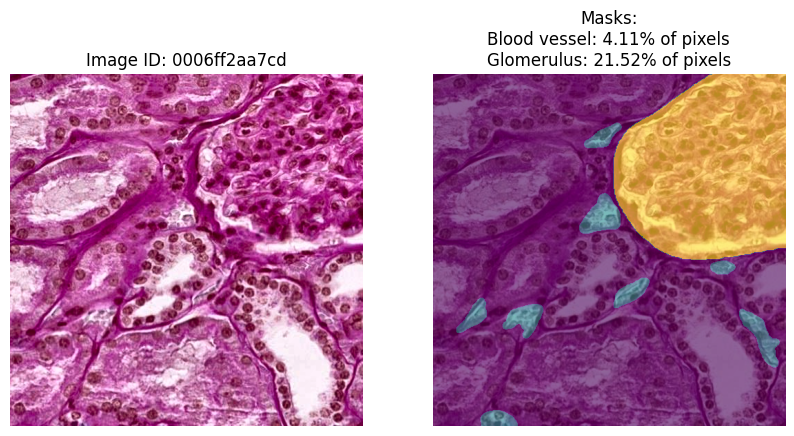

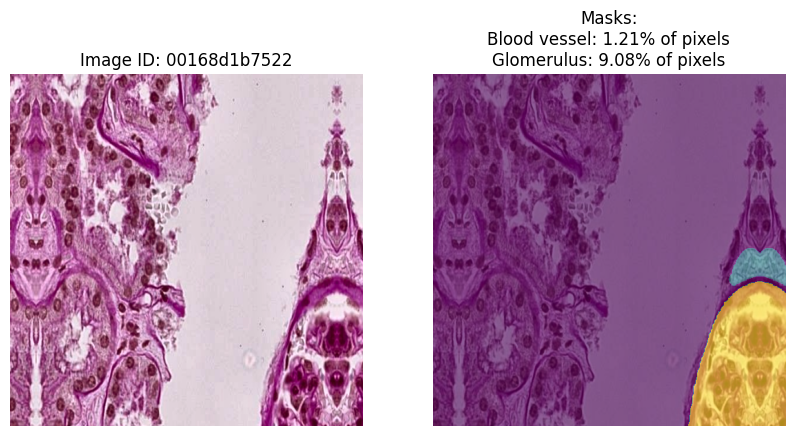

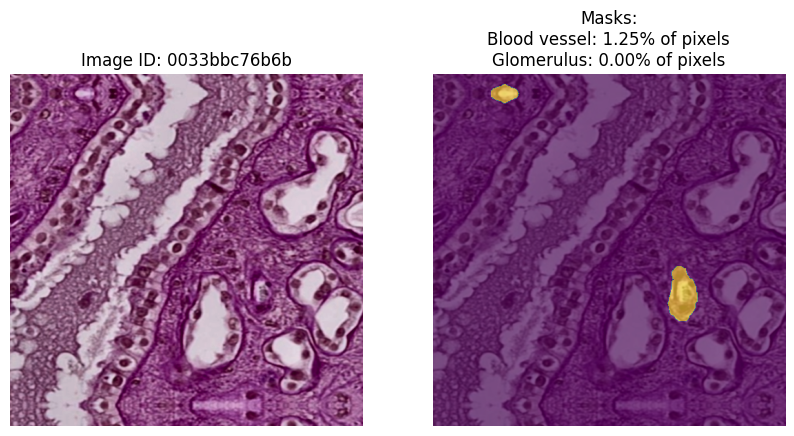

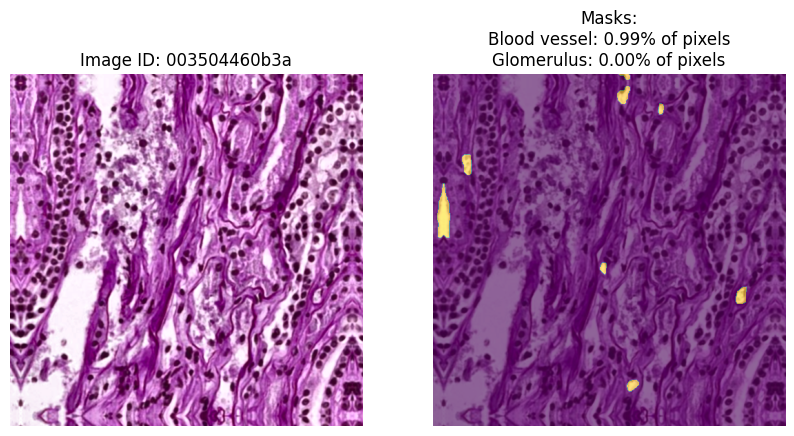

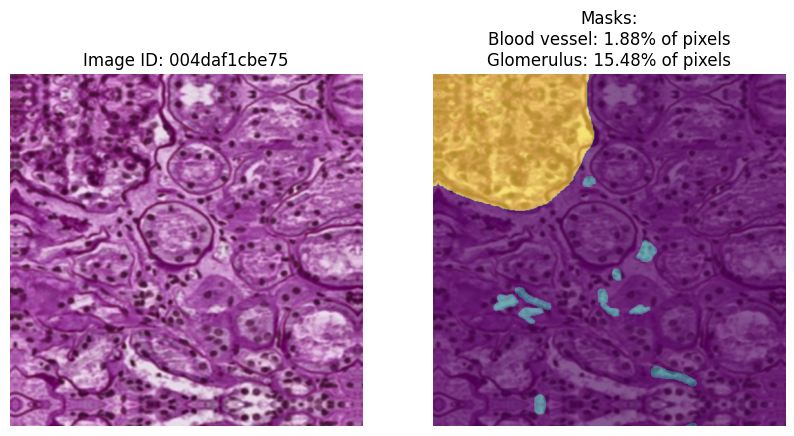

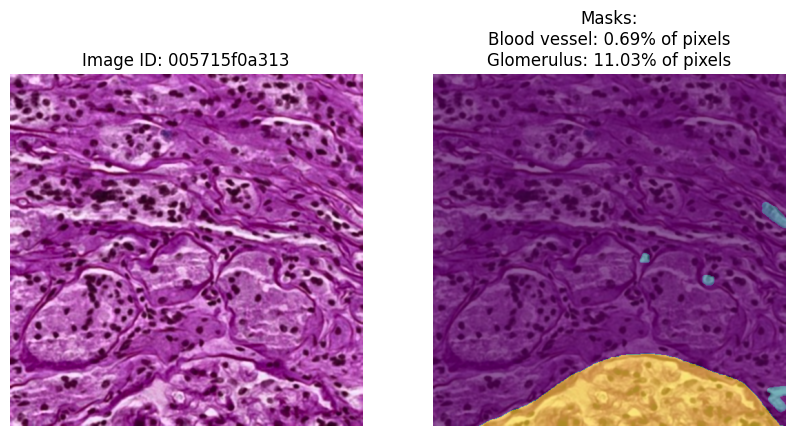

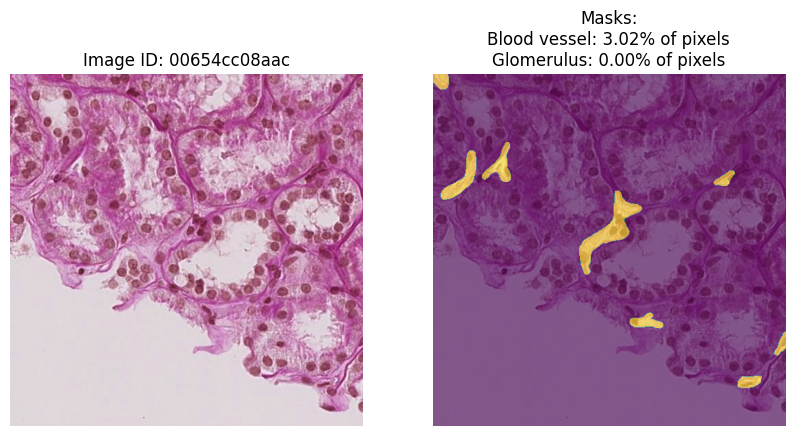

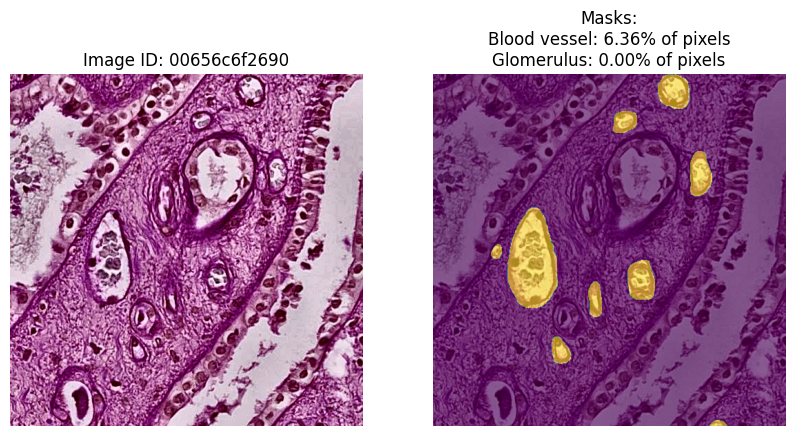

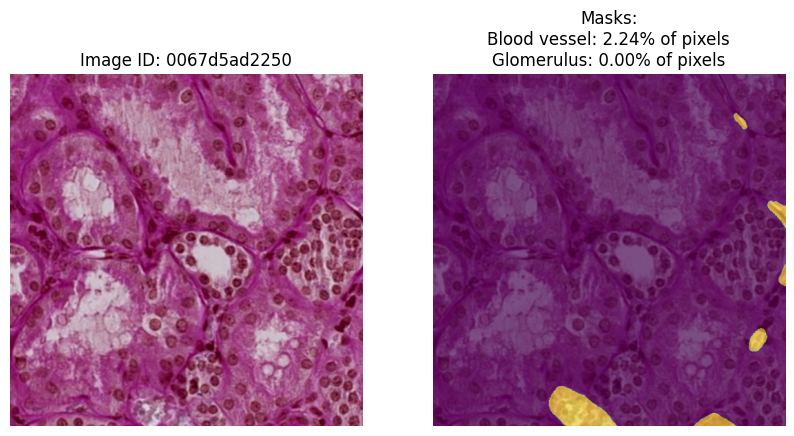

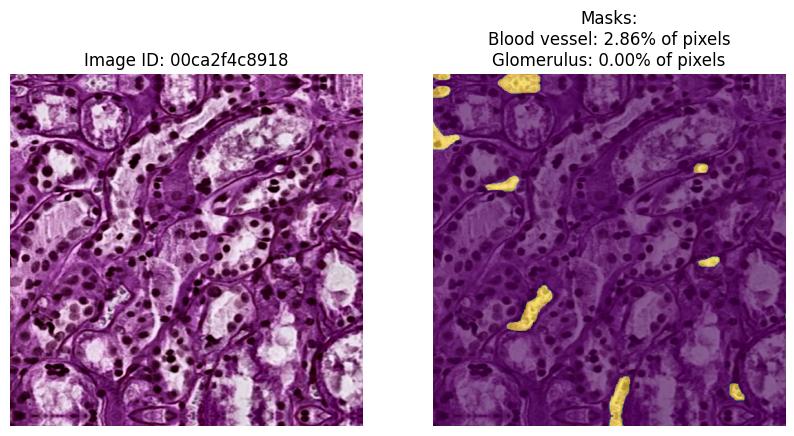

In [6]:
def visualize_sample(sample):
    """ Visualize image, mask, and class ratios """
    masks = sample[1].permute(1, 2, 0).numpy()
    image = sample[0].permute(1, 2, 0).numpy()

    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(10, 7))
    axs[0].imshow(image)
    axs[0].set_title(f"Image ID: {sample[2]}")
    axs[0].axis("off")
    axs[1].imshow(image)
    axs[1].imshow(masks, alpha=0.6)
    axs[1].axis("off")

    # Calculate pixel ratios for each class
    total_pixels = 512*512
    class_pixel_counts = {class_num: np.sum(masks == class_num) for class_num in CFG.cls_dict.values() if class_num!=0 }
    class_ratios = {class_num: count / total_pixels for class_num, count in class_pixel_counts.items()}

    # Display class names and their pixel ratios
    mask_info = []
    for class_num, ratio in class_ratios.items():
        class_name = "Blood vessel" if class_num == 1 else "Glomerulus"
        mask_info.append(f"{class_name}: {ratio:.2%} of pixels")            
    axs[1].set_title(f"Masks:\n{mask_info[0]}\n{mask_info[1]}")
    plt.show()

# Visualize a few samples
samples = [HMD[i] for i in range(10)]
for sample in samples:
    visualize_sample(sample)


In the introduction notebook I explored some statistical insights of the problem. The most important information was the class proportion stat. Even though it presented a fairly balanced ratio between the target classes, we can also note that the background pixels covered the majority of the image samples, meaning that it still might be advantageous to apply class weighting to balance the loss function by scaling up the relevance of the target features.

In [7]:
def calculate_class_stats(samples, num_classes, device, dataset_type='train', print_info=False):
    """ Calculate class ratios and class weights 
        for the CrossEntropyLoss function to address class imbalance issues.
    """
    start = datetime.now()

    # Loop through samples to calculate class counts
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0
    for s in samples:
        _, msk, _ = s
        msk_np = msk.numpy()
        total_pixels += msk_np.size

        # Count occurrences of each class in the mask
        for class_idx in range(num_classes):
            class_counts[class_idx] += np.sum(msk_np == class_idx)

    # Calculate class weights for CrossEntropyLoss
    class_weights = np.zeros(num_classes, dtype=np.float32)
    for i in range(num_classes):
        if class_counts[i] > 0:  # Avoid division by zero error
            class_weights[i] = total_pixels / class_counts[i]
        else:
            class_weights[i] = 0  # If no pixels of that class, weight is 0

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Calculate class ratios for class imbalance measurement
    clss = ['background','blood_vessel', 'glomerulus']
    class_ratios = {f"{cls_name}": class_counts[cls_val] / total_pixels if total_pixels > 0 else 0.0 
                    for cls_name, cls_val in CFG.cls_dict.items()}
    # class_ratios['background'] = 1 - sum(class_ratios.values())

    end = datetime.now() - start
    if print_info:
        print(f"\nResults for {dataset_type} dataset:")
        print(f"Class counts: {class_counts} px")
        print(f"Total pixels: {total_pixels} px")
        print(f"Class weights: {class_weights}")
        print(f"Class ratios:")
        for cls, rat in class_ratios.items():
            print(f"   - {cls}: {rat*100:.1f} %")        
        print(f"\nFunction time (hh:mm:ss:ms): {end}")

    return class_weights_tensor, class_ratios

# Calculate class weights and ratios for the train and validation datasets
pos_weights, train_class_ratios = calculate_class_stats(train_set, num_classes=CFG.num_classes, device=device, dataset_type="Train", print_info=True)
_, valid_class_ratios = calculate_class_stats(val_set, num_classes=CFG.num_classes, device=device, dataset_type="Validation", print_info=True)


Results for Train dataset:
Class counts: [273972684  13513524  12406528] px
Total pixels: 299892736 px
Class weights: [ 1.0946082 22.192045  24.172173 ]
Class ratios:
   - background: 91.4 %
   - blood_vessel: 4.5 %
   - glomerulus: 4.1 %

Function time (hh:mm:ss:ms): 0:02:13.607448

Results for Validation dataset:
Class counts: [113837673   5455122   4701317] px
Total pixels: 123994112 px
Class weights: [ 1.0892186 22.72985   26.374336 ]
Class ratios:
   - background: 91.8 %
   - blood_vessel: 4.4 %
   - glomerulus: 3.8 %

Function time (hh:mm:ss:ms): 0:00:55.743783


In [8]:
# These class weights will be used (optionally) in the loss function
pos_weights

tensor([ 1.0946, 22.1920, 24.1722], device='cuda:0')

#### Conclusions

- We can see that the 2 class's relative proportion is fairly balanced (Train set: 4.5% and 4.1%; Valid set: 4.2% and 4.1%). Now we can test the class weights that are based on this ratio, whether they improve or degrade the training performance.

- The positional weights are in a tuple with 3 elements: 1. background, 2. blood_vessel, 3. glomerulus. The weight values of the target classes are scaled up to favor learning features from these minority classes (reducing the importance of the background).

(Note: These weights are based on averages and will be applied 'globally', meaning there is always a different class ratio to calculate per image or batch of images 'locally'. This means that this class weighting might not be too effective.)


### U-Net model

In this project my primary goal is to use the U-Net architecture. It has proven to be highly effective for tasks involving pixel-level classification or segmentation.

**Structure**:

Repetatively applies convolution layers, ReLU acitvation and max pooling operation in its core block.
It builds up with a downsampling and an upsampling path to explore the image instances in different dimensional space.
Then it applies a skip connection layer in every level to support the feature interpretation in the different image dimensions.

Note: According to the original U-Net paper there are 4 feature map level, plus the bottleneck, but here I added another level since it increased the accuracy of predictions a little bit. 

Note: I will also attempt to use a pretrained model encoder to transfer knowledge to the trainable part of the U-Net model. We will see it later if that approach helps the learning process or not.

**Application**:

U-Net is widely used across a variety of fields, from medical image segmentation to satellite imaging. This is the reason why I chose it as my baseline model.

In [9]:
# # default might be better(uniform), but test it
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, in_filters=32, num_classes=4):
        super().__init__()
        self.num_classes = num_classes
        
        # Donwsample
        self.encoder1 = ConvBlock(in_channels, in_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(in_filters, in_filters*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(in_filters*2, in_filters*4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(in_filters*4, in_filters*8)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(in_filters*8, in_filters*16)
        self.pool5 = nn.MaxPool2d(2)

        # Bottom layer
        self.bottleneck = ConvBlock(in_filters*16, in_filters*32)

        # Upsample
        self.upconv5 = nn.ConvTranspose2d(in_filters*32, in_filters*16, 2, stride=2, output_padding=0,) # if im size like 256*256 set it to 0
        self.decoder5 = ConvBlock(in_filters*32, in_filters*16)
        self.upconv4 = nn.ConvTranspose2d(in_filters*16, in_filters*8, 2, stride=2)
        self.decoder4 = ConvBlock(in_filters*16, in_filters*8)
        self.upconv3 = nn.ConvTranspose2d(in_filters*8, in_filters*4, 2, stride=2)
        self.decoder3 = ConvBlock(in_filters*8, in_filters*4)
        self.upconv2 = nn.ConvTranspose2d(in_filters*4, in_filters*2, 2, stride=2)
        self.decoder2 = ConvBlock(in_filters*4, in_filters*2)
        self.upconv1 = nn.ConvTranspose2d(in_filters*2, in_filters, 2, stride=2)
        self.decoder1 = ConvBlock(in_filters*2, in_filters)
            
        # Classifier
        self.conv = nn.Conv2d(in_filters, num_classes, 1)

        # Initialize weights for given layers
        self.apply(init_weights)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)
        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)
        enc5 = self.encoder5(pool4)
        pool5 = self.pool5(enc5)
        
        bottleneck = self.bottleneck(pool5)
        
        upconv5 = self.upconv5(bottleneck)
        cat5 = torch.cat([upconv5, enc5], dim=1)
        dec5 = self.decoder5(cat5)        
        upconv4 = self.upconv4(dec5)
        cat4 = torch.cat([upconv4, enc4], dim=1)
        dec4 = self.decoder4(cat4)
        upconv3 = self.upconv3(dec4)
        cat3 = torch.cat([upconv3, enc3], dim=1)
        dec3 = self.decoder3(cat3)
        upconv2 = self.upconv2(dec3)
        cat2 = torch.cat([upconv2, enc2], dim=1)
        dec2 = self.decoder2(cat2)
        upconv1 = self.upconv1(dec2)
        cat1 = torch.cat([upconv1, enc1], dim=1)
        dec1 = self.decoder1(cat1)
        
        return self.conv(dec1)

In [10]:
# Create Unet
unet_model = UNet(in_filters=CFG.filters, num_classes=CFG.num_classes)
unet_model.to(device)

# # Test model on dummy input
summary(unet_model, input_size=(1,3,512,512), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
UNet                                     [1, 3, 512, 512]          [1, 3, 512, 512]          --                        True
├─ConvBlock: 1-1                         [1, 3, 512, 512]          [1, 16, 512, 512]         --                        True
│    └─Sequential: 2-1                   [1, 3, 512, 512]          [1, 16, 512, 512]         --                        True
│    │    └─Conv2d: 3-1                  [1, 3, 512, 512]          [1, 16, 512, 512]         448                       True
│    │    └─BatchNorm2d: 3-2             [1, 16, 512, 512]         [1, 16, 512, 512]         32                        True
│    │    └─ReLU: 3-3                    [1, 16, 512, 512]         [1, 16, 512, 512]         --                        --
│    │    └─Conv2d: 3-4                  [1, 16, 512, 512]         [1, 16, 512, 512]         2,320                     True
│    

### Transfer learning

Here I am planning to create a hybrid model that fuses a Resnet model (serving as encoder) with the U-net structure (serving as decoder). Unfortunately I had issues with this implementation, since the Resnet layers are different from my model architecture. The main problem is that skip connections can only be created between lower sized featuremaps of the Resnet (128x128, 64x64 and below...). This reduces the transfer learning capabilities very much, resulting a less efficient model.

In [11]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=78061808f6f75a2ce4618ed34166f5f657a26e940a54b895cdbe8ed4d222cf7f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a91e45026dacfe0c6fed495c82b33cb21ae26ff4a0ede8caae1fe0ac34fd103e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [12]:
import segmentation_models_pytorch as smp

In [13]:
res_encoder = smp.encoders.get_encoder(
    "resnet34", in_channels=3, depth=5, pretrained=True
)

# Inspect Resnet model layers
for module_name, module in res_encoder.named_modules():
    print(f"module_name : {module_name} ")# , value : {module}")


module_name :  
module_name : conv1 
module_name : bn1 
module_name : relu 
module_name : maxpool 
module_name : layer1 
module_name : layer1.0 
module_name : layer1.0.conv1 
module_name : layer1.0.bn1 
module_name : layer1.0.relu 
module_name : layer1.0.conv2 
module_name : layer1.0.bn2 
module_name : layer1.1 
module_name : layer1.1.conv1 
module_name : layer1.1.bn1 
module_name : layer1.1.relu 
module_name : layer1.1.conv2 
module_name : layer1.1.bn2 
module_name : layer1.2 
module_name : layer1.2.conv1 
module_name : layer1.2.bn1 
module_name : layer1.2.relu 
module_name : layer1.2.conv2 
module_name : layer1.2.bn2 
module_name : layer2 
module_name : layer2.0 
module_name : layer2.0.conv1 
module_name : layer2.0.bn1 
module_name : layer2.0.relu 
module_name : layer2.0.conv2 
module_name : layer2.0.bn2 
module_name : layer2.0.downsample 
module_name : layer2.0.downsample.0 
module_name : layer2.0.downsample.1 
module_name : layer2.1 
module_name : layer2.1.conv1 
module_name : laye

In [14]:
class UNetWithResnet(nn.Module):
    """ Apply transfer learning with a pretrained Resnet34 model as encoder.
    """
    def __init__(self, in_channels=3, in_filters=16, num_classes=3):
        super().__init__()
        self.num_classes = num_classes

        # Encoder
        self.encoder = smp.encoders.get_encoder("resnet34", in_channels=in_channels, depth=5, pretrained=True)
        # Note: Resnet has a different structure than Unet so the skip connection layer shapes must match.
        # enc1 layer shape: torch.Size([1, 64, 128, 128])
        # enc2 layer shape: torch.Size([1, 64, 128, 128])
        # enc3 layer shape: torch.Size([1, 128, 64, 64])
        # enc4 layer shape: torch.Size([1, 256, 32, 32])
        # enc5 layer shape: torch.Size([1, 512, 16, 16])

        # Freeze the parameters of Resnet34
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Bottom layer (bottleneck)
        self.bottleneck = ConvBlock(in_filters*32, in_filters*64)

        # Upsample
        # Here I will leave out the first upconv operation to match filters and feature maps in the encoder
        self.decoder5 = ConvBlock(in_filters*64, in_filters*32)  # Corresponding to bottleneck
        
        self.upconv4 = nn.ConvTranspose2d(in_filters*32, in_filters*16, 2, stride=2, output_padding=0)
        self.decoder4 = ConvBlock(in_filters*32, in_filters*16)

        self.upconv3 = nn.ConvTranspose2d(in_filters*16, in_filters*8, 2, stride=2, output_padding=0)
        self.decoder3 = ConvBlock(in_filters*16, in_filters*8)

        self.upconv2 = nn.ConvTranspose2d(in_filters*8, in_filters*4, 2, stride=2, output_padding=0)
        self.decoder2 = ConvBlock(in_filters*8, in_filters*4)

        # Also leaving out the upconv operation here to match encoder design
        # self.upconv1 = nn.ConvTranspose2d(in_filters*4, in_filters*2, 2, stride=2, output_padding=0)
        self.decoder1 = ConvBlock(in_filters*4, in_filters*2)

        # Adding 2 upconv layers to scale feature maps to input image size
        # (we could just use F.interpolate, but it wont add learnable features)
        self.upconv_last1 = nn.ConvTranspose2d(in_filters*2, in_filters*2, 2, stride=2, output_padding=0)
        self.upconv_last2 = nn.ConvTranspose2d(in_filters*2, in_filters, 2, stride=2, output_padding=0)

        # Classifier
        self.final_conv = nn.Conv2d(in_filters, num_classes, 1)
        
    def forward(self, x):
        enc1 = self.encoder.conv1(x)
        enc1 = self.encoder.bn1(enc1)
        enc1 = self.encoder.relu(enc1)
        enc1 = self.encoder.maxpool(enc1)
        enc2 = self.encoder.layer1(enc1)
        enc3 = self.encoder.layer2(enc2)
        enc4 = self.encoder.layer3(enc3)
        enc5 = self.encoder.layer4(enc4)

        bottleneck = self.bottleneck(enc5)

        dec5 = self.decoder5(bottleneck)
        upc4 = self.upconv4(dec5)
        cat4 = torch.cat([upc4, enc4], dim=1)
        dec4 = self.decoder4(cat4)
        upc3 = self.upconv3(dec4)
        cat3 = torch.cat([upc3, enc3], dim=1)
        dec3 = self.decoder3(cat3)
        upc2 = self.upconv2(dec3)
        cat2 = torch.cat([upc2, enc2], dim=1)
        dec2 = self.decoder2(cat2)

        # upc1 = self.upconv1(dec2)
        # cat1 = torch.cat([upc1, enc1], dim=1)
        # dec1 = self.decoder1(cat1)
        dec1 = self.decoder1(dec2)

        last_upconvs = self.upconv_last2(self.upconv_last1(dec1))
        final_conv = self.final_conv(last_upconvs)
        
        return final_conv

In [15]:
unet_with_resnet = UNetWithResnet(in_channels=CFG.in_ch, in_filters=16, num_classes=CFG.num_classes)
summary(unet_with_resnet, input_size=(1,3,512,512), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
UNetWithResnet                                [1, 3, 512, 512]          [1, 3, 512, 512]          --                        Partial
├─ResNetEncoder: 1-1                          --                        --                        --                        False
│    └─Conv2d: 2-1                            [1, 3, 512, 512]          [1, 64, 256, 256]         (9,408)                   False
│    └─BatchNorm2d: 2-2                       [1, 64, 256, 256]         [1, 64, 256, 256]         (128)                     False
│    └─ReLU: 2-3                              [1, 64, 256, 256]         [1, 64, 256, 256]         --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 256, 256]         [1, 64, 128, 128]         --                        --
│    └─Sequential: 2-5                        [1, 64, 128, 128]         [1, 64, 128, 128] 

In [16]:
class UNetWithResnetHybrid(nn.Module):
    """ Apply transfer learning with a pretrained Resnet34 model as encoder.
    """
    def __init__(self, in_channels=3, in_filters=16, num_classes=3):
        super().__init__()
        self.num_classes = num_classes

        # Encoder
        self.encoder = smp.encoders.get_encoder("resnet34", in_channels=in_channels, depth=5, pretrained=True)

        # Freeze the parameters of Resnet34
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Bottom layer (bottleneck)
        self.bottleneck = ConvBlock(in_filters*32, in_filters*32)

        # Upsample
        # Here I will leave out the first upconv operation to match filters and feature maps in the encoder
        self.decoder5 = ConvBlock(in_filters*32, in_filters*32)  # Corresponding to bottleneck
        
        self.upconv4 = nn.ConvTranspose2d(in_filters*32, in_filters*16, 2, stride=2, output_padding=0)
        self.decoder4 = ConvBlock(in_filters*32, in_filters*16)

        self.upconv3 = nn.ConvTranspose2d(in_filters*16, in_filters*8, 2, stride=2, output_padding=0)
        self.decoder3 = ConvBlock(in_filters*16, in_filters*8)

        self.upconv2 = nn.ConvTranspose2d(in_filters*8, in_filters*4, 2, stride=2, output_padding=0)
        self.decoder2 = ConvBlock(in_filters*8, in_filters*4)

        # Also leaving out the upconv operation here to match encoder design
        # self.upconv1 = nn.ConvTranspose2d(in_filters*4, in_filters*2, 2, stride=2, output_padding=0)
        self.decoder1 = ConvBlock(in_filters*4, in_filters*2)

        # Adding 2 upconv layers to scale feature maps to input image size
        # (we could just use F.interpolate, but it wont add learnable features)
        self.upconv_last1 = nn.ConvTranspose2d(in_filters*2, in_filters*2, 2, stride=2, output_padding=0)
        self.upconv_last2 = nn.ConvTranspose2d(in_filters*2, in_filters, 2, stride=2, output_padding=0)

        # Classifier
        self.final_conv = nn.Conv2d(in_filters, num_classes, 1)
        
    def forward(self, x):
        enc1 = self.encoder.conv1(x)
        enc1 = self.encoder.bn1(enc1)
        enc1 = self.encoder.relu(enc1)
        enc1 = self.encoder.maxpool(enc1)
        enc2 = self.encoder.layer1(enc1)
        enc3 = self.encoder.layer2(enc2)
        enc4 = self.encoder.layer3(enc3)
        enc5 = self.encoder.layer4(enc4)

        bottleneck = self.bottleneck(enc5)

        dec5 = self.decoder5(bottleneck)
        upc4 = self.upconv4(dec5)
        cat4 = torch.cat([upc4, enc4], dim=1)
        dec4 = self.decoder4(cat4)
        upc3 = self.upconv3(dec4)
        cat3 = torch.cat([upc3, enc3], dim=1)
        dec3 = self.decoder3(cat3)
        upc2 = self.upconv2(dec3)
        cat2 = torch.cat([upc2, enc2], dim=1)
        dec2 = self.decoder2(cat2)

        # upc1 = self.upconv1(dec2)
        # cat1 = torch.cat([upc1, enc1], dim=1)
        # dec1 = self.decoder1(cat1)
        dec1 = self.decoder1(dec2)

        last_upconvs = self.upconv_last2(self.upconv_last1(dec1))
        final_conv = self.final_conv(last_upconvs)
        
        return final_conv

In [17]:
unet_with_resnet = UNetWithResnetHybrid(in_channels=CFG.in_ch, in_filters=16, num_classes=CFG.num_classes)
summary(unet_with_resnet, input_size=(1,3,512,512), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
UNetWithResnetHybrid                          [1, 3, 512, 512]          [1, 3, 512, 512]          --                        Partial
├─ResNetEncoder: 1-1                          --                        --                        --                        False
│    └─Conv2d: 2-1                            [1, 3, 512, 512]          [1, 64, 256, 256]         (9,408)                   False
│    └─BatchNorm2d: 2-2                       [1, 64, 256, 256]         [1, 64, 256, 256]         (128)                     False
│    └─ReLU: 2-3                              [1, 64, 256, 256]         [1, 64, 256, 256]         --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 256, 256]         [1, 64, 128, 128]         --                        --
│    └─Sequential: 2-5                        [1, 64, 128, 128]         [1, 64, 128, 128] 

### Training

In [18]:
# Lovász-Softmax loss modified version of https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

class LovaszSoftmaxLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights
        
    @staticmethod
    def lovasz_grad(gt_sorted):
        """
        Computes gradient of the Lovasz extension w.r.t sorted errors.
        """
        gts = gt_sorted.sum()  # Total ground truth positive pixels
        intersection = gts - gt_sorted.cumsum(0)
        union = gts + (1 - gt_sorted).cumsum(0)
        jaccard = 1. - intersection / union
        jaccard[1:] = jaccard[1:] - jaccard[:-1]  # Gradients
        return jaccard

    def forward(self, logits, labels, ignore_index=None):
        """
        Lovász-Softmax loss for multiclass segmentation.
          logits: [B, C, H, W] Tensor, raw predictions (before softmax).
          labels: [B, H, W] Tensor, ground truth with class indices (0 to C-1).
          ignore_index: Label to ignore in loss calculation, optional.
        """
        # Apply softmax to calculate probabilities
        probas = F.softmax(logits, dim=1)  # [B, C, H, W]
        B, C, H, W = probas.shape

        # Flatten predictions and labels for processing
        probas = probas.permute(0, 2, 3, 1).reshape(-1, C)  # [B*H*W, C]
        labels = labels.view(-1)  # [B*H*W]

        if ignore_index is not None:
            valid = labels != ignore_index
            probas = probas[valid]
            labels = labels[valid]

        # Calculate loss for each class
        losses = []
        for c in range(C):
            fg = (labels == c).float()  # Binary mask for class c
            if fg.sum() == 0:
                continue  # Skip if no pixels of class c
            errors = (fg - probas[:, c]).abs()
            errors_sorted, perm = torch.sort(errors, descending=True)
            fg_sorted = fg[perm]
            grad = self.lovasz_grad(fg_sorted)

            # Compute loss for class c
            loss_c = torch.dot(errors_sorted, grad)

            # Apply class weight if provided
            weight_c = self.weights[c] if self.weights is not None else 1.0
            losses.append(weight_c * loss_c)

        # Return mean loss across all classes
        return torch.mean(torch.stack(losses)) if losses else 0.0

In [19]:
class DiceCELoss(nn.Module):
    """ Combined loss function, utilizing CE and Dice losses. """

    def __init__(self, weight=None, smooth=1e-8):
        super().__init__()
        self.weight = weight
        self.smooth = smooth

    def forward(self, outputs, targets):
        ce_loss = F.cross_entropy(outputs, targets, weight=self.weight)
        targets = targets.to(device)

        # Calculate Dice Loss
        probs = F.softmax(outputs, dim=1)
        num_classes = outputs.shape[1]
        true_1_hot = torch.eye(num_classes).to(device)
        true_1_hot = true_1_hot[targets.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        intersection = torch.sum(probs * true_1_hot, dim=(2, 3))
        union = torch.sum(probs, dim=(2, 3)) + torch.sum(true_1_hot, dim=(2, 3))
        dice_loss = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_loss.mean()

        # Combine Dice Loss and Crossentropy Loss
        combined_loss = ce_loss + dice_loss
        return combined_loss


In [20]:
def dice_score(pred_class_i, labels_i):
    """ Calculate Dice score as metric. """
    dice = (2 * (pred_class_i * labels_i).sum().item()) / ((pred_class_i + labels_i).sum().item() + 1e-8)
    return dice

def calc_stats(labels, preds, class_dict):
    """ Calculate the overall and class-related statistics."""
    pixel_acc = {}
    dice_scores = {}
    ious = {}

    pred_class = torch.argmax(preds, dim=1)
    
    for class_name, class_id in class_dict.items():
        if class_name == "background":
            continue

        # Index to predictions and labels
        pred_class_i = (pred_class == class_id).float().flatten()
        labels_i = (labels == class_id).float().flatten()
        
        # Calculate iou and dice score
        intersection = (pred_class_i * labels_i).sum().item()
        union = (pred_class_i + labels_i).sum().item() - intersection
        num_correct = (pred_class_i == labels_i).sum().item()
        num_pixels = labels_i.numel()

        # Calculate stats for each class
        if union > 0:
            pixel_acc[class_name] = num_correct / num_pixels * 100
            ious[class_name] = intersection / union * 100
            dice_scores[class_name] = dice_score(pred_class_i, labels_i)
        else:
            pixel_acc[class_name] = 0
            ious[class_name] = 0        
            dice_scores[class_name] = 0

    return dice_scores, ious, pixel_acc

def model_trainer(train_loader, valid_loader, model, loss_fn, optimizer, scheduler, early_stop_patience, model_name="unet"):

    torch.cuda.empty_cache()
    scaler = torch.GradScaler(device.type) if CFG.mixed_precision else None
    early_stopping_counter = 0
    prev_iou = -np.Inf
    prev_loss = np.Inf
        
    history = {
        "epoch": [],
        "train_loss": [],
        "valid_loss": [],
        "p_acc": [],
        "d_score": [],
        "iou": [],
        "background": { "d_score":[], "iou":[],},
        "blood_vessel": { "d_score":[], "iou":[],},
        "glomerulus": { "d_score":[], "iou":[],},
    }

    start = datetime.now()
    for e in range(CFG.epochs):

        # TRAINING
        model.train()
        print("-" * 40)
        print(f"EPOCH {e + 1}. training step...")
        train_time_1 = datetime.now()
        loss_list = []

        for i, data in enumerate(train_loader):
            im = data[0].to(device)
            seg_gt = data[1].squeeze(1).to(device)

            with torch.autocast(device.type):
                seg_pred = model.forward(im)
                loss = loss_fn(seg_pred, seg_gt)

            # Backward and optimize
            optimizer.zero_grad()
            if CFG.mixed_precision:
                scaler.scale(loss.mean()).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            # Collect losses
            loss_list.append(loss.item())

        train_time_2 = datetime.now()- train_time_1
        print(f" - epoch training time: (hh:mm:ss:ms): {train_time_2}\n")
        
        # VALIDATION
        model.eval()
        print(f"EPOCH {e + 1}. validation step...")
        val_loss_list = []
        all_dice_scores = {class_name: 0 for class_name in CFG.cls_dict.keys()}
        all_iou = {class_name: 0 for class_name in CFG.cls_dict.keys()}
        all_pixel_acc = {class_name: 0 for class_name in CFG.cls_dict.keys()}

        for i, data in enumerate(valid_loader):
            im = data[0].to(device)
            seg_gt = data[1].squeeze(1).to(device)

            with torch.no_grad():
                seg_pred = model.forward(im)
                val_loss = loss_fn(seg_pred, seg_gt)
                val_loss_list.append(val_loss.item())
                
                ## Stats calculation
                batch_dice_scores, batch_iou, batch_pixel_acc = calc_stats(labels=seg_gt, preds=seg_pred, class_dict=CFG.cls_dict)
                
                for class_name in CFG.cls_dict.keys():
                    if class_name == "background":
                        continue
                    all_dice_scores[class_name] += batch_dice_scores[class_name]
                    all_iou[class_name] += batch_iou[class_name]
                    all_pixel_acc[class_name] += batch_pixel_acc[class_name]

        #  Take the avg of the collected losses
        avg_train_loss = np.mean(loss_list)
        avg_valid_loss = np.mean(val_loss_list)
        
        # Print out stats
        for class_name in CFG.cls_dict.keys():
            if class_name == "background":
                continue            
            all_dice_scores[class_name] /= len(valid_loader)
            all_iou[class_name] /= len(valid_loader)
            all_pixel_acc[class_name] /= len(valid_loader)
        
        overall_dice_score = sum(all_dice_scores.values()) / len(CFG.cls_dict)
        overall_iou = sum(all_iou.values()) / len(CFG.cls_dict)
        overall_pixel_acc = sum(all_pixel_acc.values()) / len(CFG.cls_dict)
        
        print(f"Results:")
        print(f" - Train epoch mean loss: {avg_train_loss:.4f}")
        print(f" - Valid epoch mean loss: {avg_valid_loss:.4f}\n")
        print("Metrics by class:")
        for class_name in CFG.cls_dict.keys():
            if class_name == "background":
                continue            
            print(f"   - '{class_name}' dice score: {all_dice_scores[class_name]:.4f}, iou: {all_iou[class_name]:.2f}%, pixel acc.: {all_pixel_acc[class_name]:.2f}%")
        
        print(f"\n - Overall dice score: {overall_dice_score:.4f}")
        print(f" - Overall iou: {overall_iou:.2f}%")
        print(f" - Overall pixel accuracy: {overall_pixel_acc:.2f}%")

        # Append stats to history
        history["epoch"].append(e + 1)
        history["train_loss"].append(avg_train_loss)
        history["valid_loss"].append(avg_valid_loss)
        history["p_acc"].append(overall_pixel_acc)
        history["d_score"].append(overall_dice_score)
        history["iou"].append(overall_iou)
        for class_name in CFG.cls_dict.keys():
            if class_name == "background":
                continue            
            history[class_name]["d_score"].append(all_dice_scores[class_name])
            history[class_name]["iou"].append(all_iou[class_name])

        # Check if both loss/iou have improved or not
        loss_is_better = avg_valid_loss < prev_loss
        iou_is_better = overall_iou > prev_iou
        
        if loss_is_better or iou_is_better:
            # At least one metric improved, reset es counter
            if loss_is_better:
                prev_loss = avg_valid_loss
                print(f" - Lower loss achieved ({prev_loss:.4f}).")
            if iou_is_better:
                prev_iou = overall_iou
                print(f" - Higher IOU achieved ({prev_iou:.4f}).")

            # Save the model state
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'./best_{model_name}_state.h5')
            
            early_stopping_counter = 0
        else:
            # Neither metric improved, increase es counter
            early_stopping_counter += 1
            print(f" - Neither valid loss nor IOU improved. Early stopping counter: {early_stopping_counter}/{early_stop_patience}")
            if early_stopping_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

        # Update LR
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_valid_loss)
        else:
            scheduler.step()
        print(f" - LR for next epoch: {optimizer.param_groups[0]['lr']}\n")
    
    time_elapsed = datetime.now() - start
    print(f"\nFinished training. (hh:mm:ss:ms): {time_elapsed}\n")

    torch.cuda.empty_cache()
    gc.collect()

    return history


In [21]:
# --- Define models ---
model = UNet(in_filters=CFG.filters, num_classes=CFG.num_classes).to(device)
h_model = UNetWithResnet(in_channels=CFG.in_ch, in_filters=CFG.filters, num_classes=CFG.num_classes).to(device)
# h_model = UNetWithResnetHybrid(in_channels=CFG.in_ch, in_filters=CFG.filters, num_classes=CFG.num_classes).to(device)

## --- Setup the loss function ---
# loss_fn = torch.nn.CrossEntropyLoss(weight=pos_weights.to(device))
loss_fn = DiceCELoss(weight=None) # got better results without cls_weights
# loss_fn = LovaszSoftmaxLoss(weights=pos_weights.to(device))

## --- Setup the optimizer ---
## (change initial learning rate for certain parts of the network)
# optimizer = torch.optim.AdamW([
#     {'params': model.bottleneck.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.decoder5.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.upconv4.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.decoder4.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.upconv3.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.decoder3.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.upconv2.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.decoder2.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.decoder1.parameters(), 'lr': CFG.init_lr*10},
# 	{'params': model.upconv_last1.parameters(), 'lr': CFG.init_lr*100},
# 	{'params': model.upconv_last2.parameters(), 'lr': CFG.init_lr*100},
# 	{'params': model.final_conv.parameters(), 'lr': CFG.init_lr*100},
# ])
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay)
h_optimizer = torch.optim.AdamW(h_model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay)

# --- Setup the scheduler ---
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=CFG.lr_patience,
    factor=CFG.lr_factor,
    min_lr=CFG.eta_min,
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=CFG.t_max,
#     eta_min=CFG.eta_min,
# )
h_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    h_optimizer,
    patience=CFG.lr_patience,
    factor=CFG.lr_factor,
    min_lr=CFG.eta_min,
)

## --- Train Unet model ---
print("*"*25);print("Unet model training:");print("*"*25)
model_hist = model_trainer(
    train_loader=train_loader,
    valid_loader=val_loader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stop_patience=CFG.early_stopping,
    model_name="unet"
)

## --- Train hybrid Resnet34 & Unet model ---
print("*"*25);print("Hybrid model training:");print("*"*25)
h_model_hist = model_trainer(
    train_loader=train_loader,
    valid_loader=val_loader,
    model=h_model,
    loss_fn=loss_fn,
    optimizer=h_optimizer,
    scheduler=h_scheduler,
    early_stop_patience=CFG.early_stopping,
    model_name="hybrid"
)

*************************
Unet model training:
*************************
----------------------------------------
EPOCH 1. training step...
 - epoch training time: (hh:mm:ss:ms): 0:02:22.033079

EPOCH 1. validation step...
Results:
 - Train epoch mean loss: 1.3150
 - Valid epoch mean loss: 1.3577

Metrics by class:
   - 'blood_vessel' dice score: 0.0000, iou: 0.00%, pixel acc.: 95.61%
   - 'glomerulus' dice score: 0.2304, iou: 13.97%, pixel acc.: 86.90%

 - Overall dice score: 0.0768
 - Overall iou: 4.66%
 - Overall pixel accuracy: 60.84%
 - Lower loss achieved (1.3577).
 - Higher IOU achieved (4.6577).
 - LR for next epoch: 0.001

----------------------------------------
EPOCH 2. training step...
 - epoch training time: (hh:mm:ss:ms): 0:02:23.563825

EPOCH 2. validation step...
Results:
 - Train epoch mean loss: 1.0375
 - Valid epoch mean loss: 0.9751

Metrics by class:
   - 'blood_vessel' dice score: 0.0000, iou: 0.00%, pixel acc.: 95.62%
   - 'glomerulus' dice score: 0.2868, iou: 19

In [22]:
# Extracting statistics for Unet
overall_stats = dict(list(model_hist.items())[:6])
mhist = pd.DataFrame(overall_stats)
mhist_bl = pd.DataFrame(model_hist["blood_vessel"])
mhist_gl = pd.DataFrame(model_hist["glomerulus"])

# Extracting statistics for the second model
overall_stats_hybrid = dict(list(h_model_hist.items())[:6])
mhist_hybrid = pd.DataFrame(overall_stats_hybrid)
mhist_bl_hybrid = pd.DataFrame(h_model_hist["blood_vessel"])
mhist_gl_hybrid = pd.DataFrame(h_model_hist["glomerulus"])

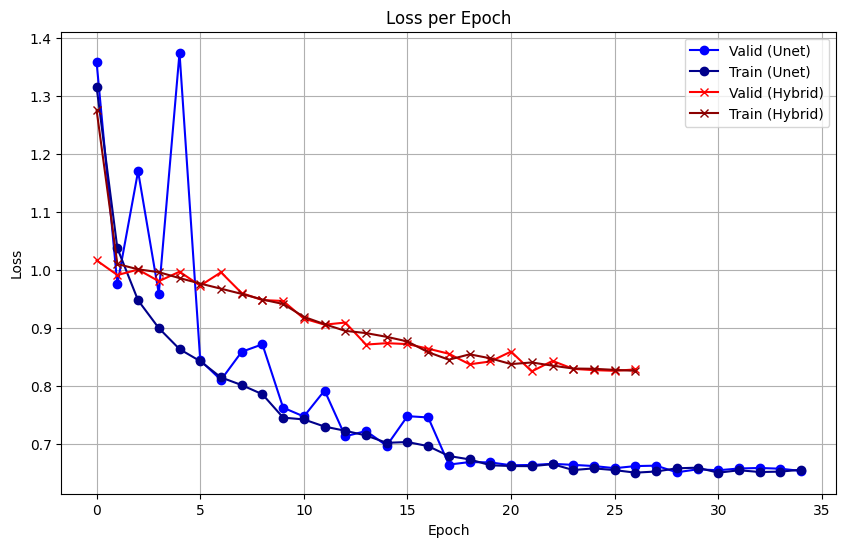

In [23]:
def plot_loss(history1, history2):
    """ Visualize loss history for both models. """
    plt.figure(figsize=(10, 6))
    plt.plot(history1['valid_loss'], label='Valid (Unet)', color="blue", marker='o')
    plt.plot(history1['train_loss'], label='Train (Unet)', color="darkblue", marker='o')
    plt.plot(history2['valid_loss'], label='Valid (Hybrid)', color="red", marker='x')
    plt.plot(history2['train_loss'], label='Train (Hybrid)', color="darkred", marker='x')
    plt.title('Loss per Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(mhist, mhist_hybrid)

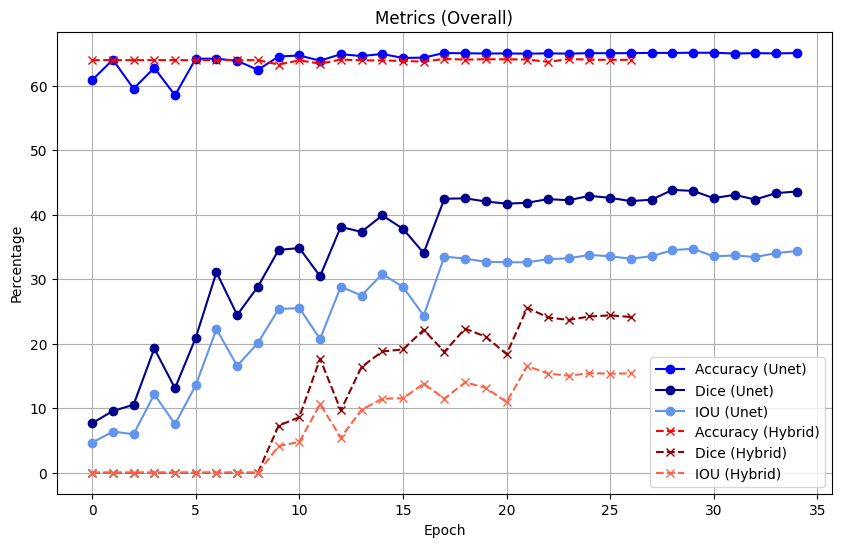

In [24]:
def plot_metrics(history1, history2):
    """ Visualize metrics history for both models. """
    plt.figure(figsize=(10, 6))
    plt.plot(history1['p_acc'], label='Accuracy (Unet)', marker='o', color="blue")
    plt.plot(history1['d_score']*100, label='Dice (Unet)', marker='o', color="darkblue")
    plt.plot(history1['iou'], label='IOU (Unet)', marker='o', color="cornflowerblue")

    plt.plot(history2['p_acc'], label='Accuracy (Hybrid)', marker='x', color="red", linestyle='--')
    plt.plot(history2['d_score']*100, label='Dice (Hybrid)', marker='x', color="darkred", linestyle='--')
    plt.plot(history2['iou'], label='IOU (Hybrid)', marker='x', color="tomato", linestyle='--')

    plt.title('Metrics (Overall)')
    plt.ylabel('Percentage')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(mhist, mhist_hybrid)

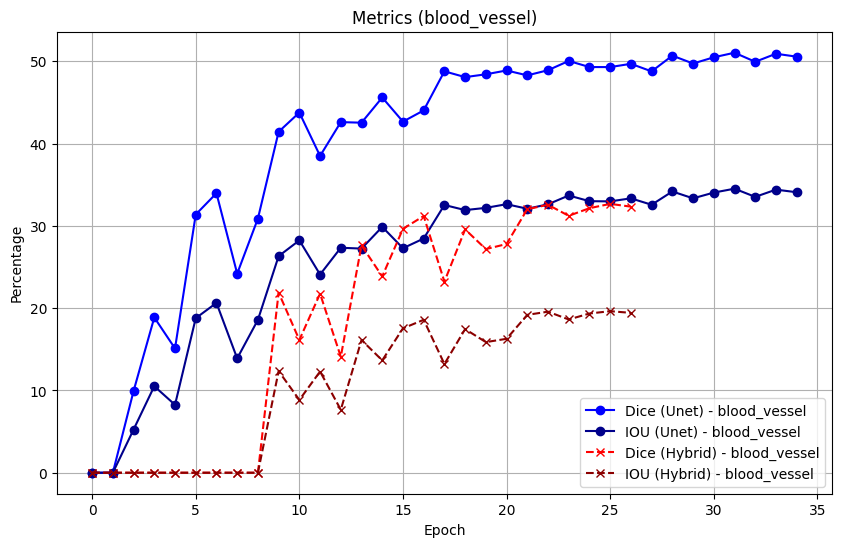

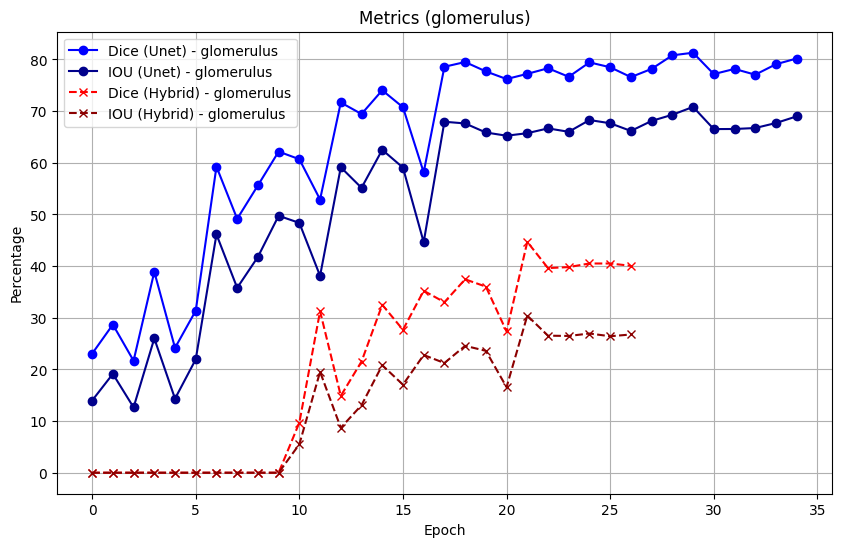

In [25]:
def plot_class_metrics(history1, history2, class_name="blood_vessel"):
    """ Visualize class related metrics history for both models. """
    plt.figure(figsize=(10, 6))
    plt.plot(history1['d_score']*100, label=f'Dice (Unet) - {class_name}', marker='o', color="blue")
    plt.plot(history1['iou'], label=f'IOU (Unet) - {class_name}', marker='o', color="darkblue")

    plt.plot(history2['d_score']*100, label=f'Dice (Hybrid) - {class_name}', marker='x', color="red", linestyle='--')
    plt.plot(history2['iou'], label=f'IOU (Hybrid) - {class_name}', marker='x', color="darkred", linestyle='--')

    plt.title(f'Metrics ({class_name})')
    plt.ylabel('Percentage')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

plot_class_metrics(mhist_bl, mhist_bl_hybrid, class_name="blood_vessel")
plot_class_metrics(mhist_gl, mhist_gl_hybrid, class_name="glomerulus")

### Inference

In [26]:
def count_pixels_to_class(mask, pred, cls_dict):
    """ Count class pixels for the mask and prediction. """
    m_unqs, m_cnts = np.unique(mask, return_counts=True)
    p_unqs, p_cnts = np.unique(pred, return_counts=True)
    mask_dict = dict(zip(m_unqs, m_cnts))
    pred_dict = dict(zip(p_unqs, p_cnts))
    
    unq_dict = {}
    for class_name, class_id in cls_dict.items():
        #Get count from mask/p, defaulting to 0 if not present
        mask_count = mask_dict.get(class_id, 0)
        pred_count = pred_dict.get(class_id, 0)
        unq_dict[class_name] = mask_count, pred_count    
    return unq_dict
    
def calculate_per_class_stats(pred_class, lbl):
    """ Calculate pixel accuracy, iou, and dice score for each target class. """
    pixel_acc = {}
    dice = {}
    iou = {}
    for class_name, class_id in CFG.cls_dict.items():
        if class_name == "background":
            continue
        pred_mask = pred_class == class_id
        true_mask = lbl == class_id

        intersection = (pred_mask & true_mask).sum().item()
        union = (pred_mask | true_mask).sum().item()

        num_correct = (pred_mask == true_mask).sum().item()
        num_pixels = torch.numel(true_mask)

        if num_correct > 0:
            pixel_acc[class_name] = num_correct / num_pixels * 100
            iou[class_name] = intersection / union * 100 if union > 0 else 0
            dice[class_name] = dice_score(pred_mask, true_mask)
        else:
            pixel_acc[class_name] = 0
            iou[class_name] = 0
            dice[class_name] = 0
    return pixel_acc, dice, iou

def calculate_overall_stats(pred_class, lbl):
    """ Calculate overall statistics of pixel accuracy, iou, and dice score. """
    num_correct = (pred_class == lbl).sum().item()
    num_pixels = torch.numel(lbl)
    intersection = (pred_class & lbl).sum().item()
    union = (pred_class | lbl).sum().item()
    pixel_acc_overall = num_correct / num_pixels * 100
    iou_overall = intersection / union * 100 if union > 0 else 0
    dice_score_overall = dice_score(pred_class, lbl)
    return pixel_acc_overall, iou_overall, dice_score_overall

def visualize_predictions(image, label, pred_class_1, pred_class_2, model_name_1, model_name_2, cls_text, ovr_text, pix_text):
    """ Create a visualization plot from the predictions. """
    pred_class_1 = pred_class_1.cpu().numpy().swapaxes(0, -1)
    pred_class_2 = pred_class_2.cpu().numpy().swapaxes(0, -1)
    image = image.cpu().numpy().swapaxes(0, -1)
    label = label.cpu().numpy().swapaxes(0, -1)

    fig, axs = plt.subplots(1, 4, figsize=(18, 7))
    plt.subplots_adjust(bottom=0.01)
    fig.text(0.15, 0.15, pix_text, va='top', ha='left', fontsize=10)
    fig.text(0.40, 0.15, cls_text, va='top', ha='left', fontsize=10)
    fig.text(0.65, 0.15, ovr_text, va='top', ha='left', fontsize=10)
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[1].imshow(image)
    axs[1].imshow(label, alpha=0.6)
    axs[1].set_title("Mask & image")
    axs[2].imshow(image)
    axs[2].imshow(pred_class_1, alpha=0.6)
    axs[2].set_title(f"{model_name_1} predictions")
    axs[3].imshow(image)
    axs[3].imshow(pred_class_2, alpha=0.6)
    axs[3].set_title(f"{model_name_2} predictions")
    for ax in axs:
        ax.axis('off')
    plt.show()


def predict_on_batch(batch_of_data, eval_model_1, eval_model_2, model_name_1="", model_name_2=""):
    for img, lbl in zip(batch_of_data[0], batch_of_data[1]):
        img = img.to(device)
        lbl = lbl.to(device)
        img_to_pred = torch.unsqueeze(img, 0).to(torch.float32)

        # Model 1 prediction
        pred_logits_1 = eval_model_1(img_to_pred)
        pred_class_1 = torch.argmax(pred_logits_1, axis=1).squeeze(0)
        # Model 2 prediction
        pred_logits_2 = eval_model_2(img_to_pred)
        pred_class_2 = torch.argmax(pred_logits_2, axis=1).squeeze(0)

        # Calculate class related stats
        pixel_acc_1, dice_1, iou_1 = calculate_per_class_stats(pred_class_1, lbl)
        pixel_acc_2, dice_2, iou_2 = calculate_per_class_stats(pred_class_2, lbl)

        # Calculate overall statistics
        pixel_acc_overall_1, iou_overall_1, dice_score_overall_1 = calculate_overall_stats(pred_class_1, lbl)
        pixel_acc_overall_2, iou_overall_2, dice_score_overall_2 = calculate_overall_stats(pred_class_2, lbl)

        # Count pixels for mask and prediction
        counts_1 = count_pixels_to_class(lbl.cpu().numpy(), pred_class_1.cpu().numpy(), CFG.cls_dict)
        counts_2 = count_pixels_to_class(lbl.cpu().numpy(), pred_class_2.cpu().numpy(), CFG.cls_dict)

        # Figure metrics info
        class_info_1, class_info_2 = "",""
        for class_name, _ in dice_1.items():
            class_info_1 += f"- {class_name}: iou: {iou_1[class_name]:.2f}%, dice score: {dice_1[class_name]:.2f}\n"
        for class_name, _ in dice_2.items():
            class_info_2 += f"- {class_name}: iou: {iou_2[class_name]:.2f}%, dice score: {dice_2[class_name]:.2f}\n"
        cls_text = f"Metrics per class:\n{model_name_1}:\n{class_info_1}\n{model_name_2}:\n{class_info_2}"

        ovr_info_1 = f"- iou: {iou_overall_1:.2f}%\n- dice score: {dice_score_overall_1:.2f}"
        ovr_info_2 = f"- iou: {iou_overall_2:.2f}%\n- dice score: {dice_score_overall_2:.2f}"
        ovr_text = f"Overall metrics:\n{model_name_1}:\n{ovr_info_1}\n\n{model_name_2}:\n{ovr_info_2}"

        pix_info_1, pix_info_2 = "",""
        for (class_name, class_id), (m_unq, p_unq) in zip(CFG.cls_dict.items(), counts_1.values()):
            pix_info_1 += f"- {class_name}: for mask: {m_unq}, for pred: {p_unq}\n"
        for (class_name, class_id), (m_unq, p_unq) in zip(CFG.cls_dict.items(), counts_2.values()):
            pix_info_2 += f"- {class_name}: for mask: {m_unq}, for pred: {p_unq}\n"
        pix_text = f"Pixel distribution for classes:\n{model_name_1}:\n{pix_info_1}\n{model_name_2}:\n{pix_info_2}"
    
        # Visualize results on both models
        visualize_predictions(img, lbl, pred_class_1, pred_class_2, model_name_1, model_name_2, cls_text, ovr_text, pix_text)


In [ ]:
## Load in trained models
best_model_1 = "/kaggle/working/best_unet_state.h5"
unet_inf_model_1 = UNet(in_filters=CFG.filters, num_classes=CFG.num_classes)
unet_inf_model_1.load_state_dict(torch.load(best_model_1))
unet_inf_model_1.eval().to(device)

best_model_2 = "/kaggle/working/best_hybrid_state.h5"
unet_inf_model_2 = UNetWithResnet(in_channels=CFG.in_ch, in_filters=CFG.filters, num_classes=CFG.num_classes)
unet_inf_model_2.load_state_dict(torch.load(best_model_2))
unet_inf_model_2.eval().to(device)

# Predict on test set
it = iter(test_loader)
batch_1 = next(it)
predict_on_batch(batch_1, unet_inf_model_1, unet_inf_model_2, model_name_1="UNet model", model_name_2="Hybrid model")
